# Analyse de données Twitter

Le jeu de données a été construit en 2021 en utilisant les librairies Twint et
Tweepy. Twint permet d'effectuer une recherche sur Twitter avec des
mots-clés et d’autres paramètres (nombre de like/retweet
minimum - ici 15 pour les deux valeurs -, intervalle de date pour la recherche, etc…) et de
récupérer les tweets contenant les mots-clés recherchés (ici "Macron", "LREM", "gouvernement", "La république en marche") au format csv ou json. Tout cela sans passer par l’A.P.I Twitter et donc sans être
limité en termes de nombre de requêtes. Attention, depuis le rachat de Twitter par Elon Musk, de tels scraping sont devenus beaucoup plus compliqués.

In [ ]:
import pandas as pd
import json
import numpy as np
import re
import ast
import dask.dataframe as ddf
import dask.multiprocessing
import networkx as nx
import matplotlib.pyplot as plt

## Import des données

### Extraction des tweets dans un dataframe tweets_df

Le jeu de données comporte 12 fichiers par an pour les années 2016 à 2020. Commencez pour assembler ces fichiers en multithread avec Dask et convertissez l'ensemble des tweets en dataframe Pandas.

In [ ]:
dask.config.set(scheduler='processes', num_workers=8)

dtypes = {'place': 'object'} # Il y a une erreur sans cette ligne

df = ddf.read_csv('./tweets/*/*.csv', dtype=dtypes)

tweets_df = df.compute()

print(tweets_df.head())

                   id     conversation_id               created_at  \
0  693583236950265858  693583236950265858  2016-01-31 00:55:04 CET   
1  693545673539637249  693545673539637249  2016-01-30 22:25:48 CET   
2  693470580142637057  693470580142637057  2016-01-30 17:27:25 CET   
3  693469503716462592  693469503716462592  2016-01-30 17:23:08 CET   
4  693446559980216320  693446559980216320  2016-01-30 15:51:58 CET   

         date      time  timezone    user_id      username  \
0  2016-01-31  00:55:04       100   16870324         sympl   
1  2016-01-30  22:25:48       100  342011546     ripisylve   
2  2016-01-30  17:27:25       100  112485961   kh_bbcleeds   
3  2016-01-30  17:23:08       100   65068197  officialbwfc   
4  2016-01-30  15:51:58       100  267310445    dfasquelle   

                 name place  ... geo source user_rt_id user_rt retweet_id  \
0  Hold ☀n, Pain Ends   NaN  ... NaN    NaN        NaN     NaN        NaN   
1                   🐘   NaN  ... NaN    NaN        N

### Extraction des informations utilisateurs depuis les tweets minés dans un dataframe que vous appelerez user_df

N'oubliez pas de retirer les duplicats ! (Un même utilisateur peut évidemment être l'auteur de plusieurs tweets...)

In [ ]:
user_columns = ['user_id', 'username', 'name']
user_data = tweets_df[user_columns]

# Supprimer les duplicats
user_df = user_data.drop_duplicates(subset='user_id')

print(user_df.head())


     user_id      username                name
0   16870324         sympl  Hold ☀n, Pain Ends
1  342011546     ripisylve                   🐘
2  112485961   kh_bbcleeds    Katherine Hannah
3   65068197  officialbwfc    Bolton Wanderers
4  267310445    dfasquelle    Daniel Fasquelle


### Extraction des mentions depuis les tweets dans un dataframe mentions_df

In [ ]:
mentions = tweets_df['tweet'].str.findall(r'@(\w+)')

mentions_df = pd.DataFrame({'tweet': tweets_df['tweet'], 'mentions': mentions})

print(mentions_df.head())

                                               tweet           mentions
0  Le gouvernement italien compte s'asseoir sur l...  [lamanifpourtous]
1  La déclaration d'Emmanuel Macron au sujet des ...                 []
2  Crowd at Macron today 17,336 with 6,630 Leeds ...         [WYSdaily]
3  17,336 in attendance at Macron Stadium for thi...                 []
4  Ouvrez les yeux,  monsieur Cazeneuve, le gouve...                 []


### Extraction des Hashtags dans un dataframe hashtags_df

In [ ]:
hashtags = tweets_df['tweet'].apply(lambda x: re.findall(r'#(\w+)', x))

hashtags_df = pd.DataFrame({'tweet': tweets_df['tweet'], 'hashtags': hashtags})

print(hashtags_df.head())


                                               tweet                  hashtags
0  Le gouvernement italien compte s'asseoir sur l...                        []
1  La déclaration d'Emmanuel Macron au sujet des ...                   [taxis]
2  Crowd at Macron today 17,336 with 6,630 Leeds ...              [bwfc, lufc]
3  17,336 in attendance at Macron Stadium for thi...  [EmiratesFACup, BOLvLEE]
4  Ouvrez les yeux,  monsieur Cazeneuve, le gouve...                        []


### Extraction des tweets étant des réponses dans un dataframe reply_to_df

In [ ]:
reply_tweets = tweets_df[tweets_df['reply_to'].notnull()]

reply_to_df = pd.DataFrame(reply_tweets)

print(reply_to_df.head())

                   id     conversation_id               created_at  \
0  693583236950265858  693583236950265858  2016-01-31 00:55:04 CET   
1  693545673539637249  693545673539637249  2016-01-30 22:25:48 CET   
2  693470580142637057  693470580142637057  2016-01-30 17:27:25 CET   
3  693469503716462592  693469503716462592  2016-01-30 17:23:08 CET   
4  693446559980216320  693446559980216320  2016-01-30 15:51:58 CET   

         date      time  timezone    user_id      username  \
0  2016-01-31  00:55:04       100   16870324         sympl   
1  2016-01-30  22:25:48       100  342011546     ripisylve   
2  2016-01-30  17:27:25       100  112485961   kh_bbcleeds   
3  2016-01-30  17:23:08       100   65068197  officialbwfc   
4  2016-01-30  15:51:58       100  267310445    dfasquelle   

                 name place  ... source user_rt_id user_rt retweet_id  \
0  Hold ☀n, Pain Ends   NaN  ...    NaN        NaN     NaN        NaN   
1                   🐘   NaN  ...    NaN        NaN     NaN  

### Extraction des liens des tweets dans un dataframe tweets_df

In [ ]:
tweets_df['links'] = tweets_df['tweet'].apply(lambda x: re.findall(r'(https?://\S+)', x))

print(tweets_df[['tweet', 'links']].head())


                                               tweet  \
0  Le gouvernement italien compte s'asseoir sur l...   
1  La déclaration d'Emmanuel Macron au sujet des ...   
2  Crowd at Macron today 17,336 with 6,630 Leeds ...   
3  17,336 in attendance at Macron Stadium for thi...   
4  Ouvrez les yeux,  monsieur Cazeneuve, le gouve...   

                       links  
0  [https://t.co/Cm85kIG640]  
1  [https://t.co/O5MEInKRfF]  
2  [https://t.co/Xpkq6Yu0Io]  
3                         []  
4  [https://t.co/SjxLwuHMhb]  


### Extraction des liens des tweets dans un dataframe link_df

In [ ]:
#link

### Écriture sur disque

Persistez maintenant les données sur disque en utilisant les formats csv, puis parquet, comparez la taille des fichiers obtenus. Comment expliquez-vous les différences ? Pour parquet, expliquez vos décisions quant aux buckets et au partitionnement. Veillez à bien utiliser toutes les ressources de votre machine.

In [ ]:
tweets_df.to_csv('tweets.csv', index=False)
mentions_df.to_csv('mentions.csv', index=False)
hashtags_df.to_csv('hashtags.csv', index=False)
reply_to_df.to_csv('reply_to.csv', index=False)
link_df.to_csv('link.csv', index=False)

tweets_df.to_parquet('tweets.parquet', engine='pyarrow')
mentions_df.to_parquet('mentions.parquet', engine='pyarrow')
hashtags_df.to_parquet('hashtags.parquet', engine='pyarrow')
reply_to_df.to_parquet('reply_to.parquet', engine='pyarrow')
link_df.to_parquet('link.parquet', engine='pyarrow')

# Parquet utilise moins de place grâce au stockage par colonnes (csv stocke de manière séquentielle), les valeurs similaires sont regroupées
# Parquet utilise des techniques de compression et peut utiliser des types de données, qui permettent un meilleur stockage en terme d'espace

### Exploration des données avec SparkSQL


Faites parler vos données à l'aide d'une dizaine de requêtes, soyez créatifs. Exemples de requêtes :
- Quels sont les utilisateurs possédant le plus de retweets en moyenne
- Quels utilisateurs posséde le plus grand nombre de like en moyenne sur l'ensemble de ses tweets utilisant un hashtag "LREM"

Essayez également d'émuler une requête CTE récursive (e.g., les utilisateurs utilisant le hashtagf LREM mais ne suivant Macron à aucun degré de distance). Vous pouvez par exemple vous inspirer de https://medium.com/globant/how-to-implement-recursive-queries-in-spark-3d26f7ed3bc9.

Utilisez EXPLAIN pour analyser :
- parsed logical plan
- analyzed logical plan
- optimized logical plan
- physical plan
Expliquez en quoi ces plans différent de ceux obtenus avec SGBD relationnel. Commentez les opérations de shuffle.

### Utilisez matpolib pour visualisez des statistiques intéressantes

Soyez créatifs...

### Visualisation de sous graphe et analyse de données avec NetworkX

La librairie NetworkX permet de manipuler des graphes. Voici un exemple simple de création et visualisation de graphe :

In [ ]:
from pyspark.sql import SparkSession

# Code to check that pyspark works as expected
spark = SparkSession.builder \
    .appName("PySpark Example") \
    .getOrCreate()
data = [("Alice", 25), ("Bob", 30), ("Charlie", 35), ("Dave", 40)]
df = spark.createDataFrame(data, ["name", "age"])
df.show()
df_filtered = df.filter(df.age > 30)
df_filtered.show()

Nodes: ['Alice', 'Bob', 'Charlie', 'Dave']
Edges: [('Alice', 'Bob'), ('Bob', 'Charlie'), ('Charlie', 'Dave')]


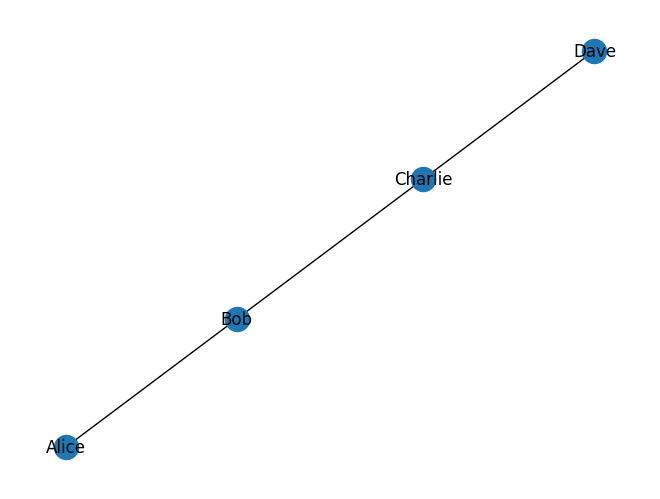

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

# Code to check that NetworkX works as expected
G = nx.Graph()

G.add_node("Alice")
G.add_node("Bob")
G.add_node("Charlie")
G.add_node("Dave")

G.add_edge("Alice", "Bob")
G.add_edge("Bob", "Charlie")
G.add_edge("Charlie", "Dave")

print("Nodes:", G.nodes)
print("Edges:", G.edges)

nx.draw(G, with_labels=True)
plt.show()

Importez et visualisez quelques sous graphes intéressants. Par exemple, visualisez le sous graphe des utilisateurs ayant "zemmour" dans leur nom. Selon la référence (Eric ou Michael) vous devriez pouvoir constater deux régions assez différentes.

## Analysez maintenant vos données au moyen des algorithmes de la librairie

Vous pouvez par exemple utiliser Pagerank, Louvain, strongly connected components, etc.

Pour les M2 ayant suivi Bases de données spécialisées, importez les données dans neo4j avec le plugging GDS et comparez.